# Programming assignment 4: Convolutional Neural Networks (100 points)
(adapted from the work done by Erik Learned-Miller, which was originally developed by Fei-Fei Li, Andrej Karpathy, and Justin Johnson)

## Overview
<font size='4'> In this assignment you will practice putting together a Convolution Neural Network (CNN) classification pipeline. So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

<font size='4'>In this assignment, you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

## Submission format
* <font size='4'>`<your_nu_username>_pa4.ipynb`
    
## Note: 
* <font size='4'>Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions. 
* <font size='4'>We have some inline questions embedded in the Jupyter notebook files. Do not miss them.
* <font size='4' color='red'>Unless specified otherwise, no for loops are allowed.

## setup

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
# from utils.classifiers.fc_net import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# You implemented such functions in PA3. Here are some reference implementations.
from utils.layers import affine_forward, affine_backward, relu_forward, relu_backward, softmax_loss

In [3]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 3


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !rm cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

/home/amina/Desktop/pa4/datasets
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  6280k      0  0:00:26  0:00:26 --:--:-- 5463k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
# Load the (preprocessed) CIFAR10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


## Part 1: Convolution layers (20 points)

<font size="4" color="red">**task 1.1: forward pass of a convolution layer. At most two nested for loops are allowed (10 points).**

In [5]:
def conv_forward_naive(x, w, b, conv_param):

    pad_parameter,stride_parameter = conv_param['pad'] ,conv_param['stride']
    # get input parameters
    N,C,H,W=x.shape
    # get filter parameters
    F,_,HH,WW=w.shape
    # shape of output parameters hight and width
    H_bar=1+(H+2*pad_parameter-HH)//stride_parameter
    W_bar=1+(W+2*pad_parameter-WW)//stride_parameter
    # initilaize output array
    out=np.zeros((N,F,H_bar,W_bar))
    #flatten filter matrix by number of filters to avoid for loop
    flattened_w=w.reshape(F,-1)
  
    # padding of input 
    x=np.pad(x,((0,),(0,),(pad_parameter,),(pad_parameter,)),mode='constant',constant_values=0)
    for i in range(H_bar):

        for j in range(W_bar):
            conv_x=x[:,:,i*stride_parameter:i*stride_parameter+HH,j*stride_parameter:j*stride_parameter+WW]
            #flatten it to get output w*x
            flconv_x=conv_x.reshape(N,-1) 
            # single step convolution + bias
            output=flconv_x.dot(flattened_w.T)+b
            out[:,:,i,j]=output
  
    
    cache = (x, w, b, conv_param)
    return out, cache

In [6]:
# check your forward pass implementation
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476575931688e-08


<font size="4" color="red">**task 1.2: backward pass of a convolution layer. At most two nested for loops are allowed (10 points).**

In [7]:
def conv_backward_naive(dout, cache):

    dx, dw, db = None, None, None
    
    ###########################################################################
    ## unpack cache tuple

    x,w,b,conv_param=cache
    #initialize padding and stride 
    pad_parameter,stride_parameter=conv_param['pad'],conv_param['stride']
    #unpack filter weights
    F,C,HH,WW=w.shape
    #unpack output 
    N,_,H_bar,W_bar=dout.shape
    #initialize gradients
    dx=np.zeros(x.shape)
    dw=np.zeros(w.shape)
    db=np.zeros(b.shape)
    #reshape weights by number of filters
    flattened_w=w.reshape(F,-1)

    for i in range(H_bar):
        for j in range(W_bar):
            dout_tra=dout[:,:,i,j]
            # confirm this line 
            dx_tra_fla=dout_tra.dot(flattened_w)
            dx_tra=dx_tra_fla.reshape(N,C,HH,WW)
            #compute dx
            dx[:,:,i*stride_parameter:i*stride_parameter+HH,j*stride_parameter:j*stride_parameter+WW] += dx_tra

            x_tra=x[:,:,i*stride_parameter:i*stride_parameter+HH,j*stride_parameter:j*stride_parameter+WW]
            x_tra_flattened=x_tra.reshape(N,-1)
            #compute dw
            dw += dout_tra.T.dot(x_tra_flattened).reshape(dw.shape)
            #compute db
            db += dout_tra.sum(axis=0)

    dx=dx[:,:,pad_parameter:-pad_parameter,pad_parameter:-pad_parameter]
          
    return dx, dw, db

In [8]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  7.99015495883212e-09
dw error:  2.6782772496622533e-10
db error:  3.8835624065741535e-11


## Part 2: Spatial Batch Normalization (32 points)
<font size='4'>Batch normalization is a very useful technique for training deep neural networks. As proposed in the original paper [1], batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

<font size='4'>Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

<font size='4'>If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

<font size='4' color='red'>**Task 2.1: forward pass of a (normal) batch norm layer (10 points).**

In [9]:
def batchnorm_forward(x, gamma, beta, bn_param):
  
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
       #compute mean
        meann=np.mean(x,axis=0)
        #compute variance of imput image
        varriance=np.var(x,axis=0)
        #compute approximated input image 
        x_app=(x-meann)/np.sqrt(varriance+eps)
        #y=w^T *x +b
        out=gamma*x_app+beta
        #store in cache tuple
        cache=(gamma,x,meann,varriance,eps,x_app)
        running_mean=momentum*running_mean+(1-momentum)*meann
        running_var=momentum*running_var+(1-momentum)*varriance
    
    elif mode == 'test':
      
        term=running_var+eps
        sc=gamma/np.sqrt(term)
        out=x*sc+(beta-running_mean*sc)
      

    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

<font size='4' color='red'>**Task 2.2: forward pass of a spatial batch norm layer (6 points).**

In [10]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
   
    out, cache = None, None

    N,C,H,W=x.shape
    #reshape input x for spatial batch normalization
    reshaped_x=x.transpose(0,3,2,1).reshape((N*H*W,C))
    #compute batchnormalization forward
    out_int,cache=batchnorm_forward(reshaped_x,gamma,beta,bn_param)
    #reshape output
    out=out_int.reshape(N,W,H,C).transpose(0,3,2,1)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return out, cache

In [11]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 1.38777878e-16  1.94289029e-17 -9.43689571e-17]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [12]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


<font size='4' color='red'>**Task 2.3: backward pass of a (normal) batch norm layer (10 points).**

In [13]:
def batchnorm_backward(dout, cache):
  
    dx, dgamma, dbeta = None, None, None
    #get parameters from cache
    gamma,x,meann,varriance,eps,x_app= cache
    N=x.shape[0]
    #compute dx,dgamma and dvariance
    dx_app=dout*gamma
    #dvar=sum(dout*gamma*(x-mean(x))-1/2(variance+eps)^-3/2)
    dvarriance=np.sum(dx_app*(x-meann)* -0.5 * np.power(varriance+eps, -1.5),axis=0)
    #dmean=sum(dx_hat*-1/(sqrt(varriance+eps)+dvariance*avrage(-2(x-mean))))
    dmeann=np.sum(dx_app *-1/np.sqrt(varriance+eps),axis=0)+dvarriance*np.mean(-2*(x-meann),axis=0)
    dx=1/np.sqrt(varriance+eps)*dx_app+dvarriance*2/N *(x-meann)+1/N*dmeann
    #dgamma=sum(x_hat*dout)
    dgamma=np.sum(x_app*dout,axis=0)
    
    dbeta=np.sum(dout,axis=0)


    return dx, dgamma, dbeta

<font size='4' color='red'>**Task 2.4: backward pass of a spatial batch norm layer (6 points).**

In [14]:
def spatial_batchnorm_backward(dout, cache):
   
    dx, dgamma, dbeta = None, None, None

    N,C,H,W=dout.shape
    dxx,dgamma,dbeta=batchnorm_backward(dout.transpose(0,3,2,1).reshape((N*H*W,C)),cache)
    dx=dxx.reshape(N,W,H,C).transpose(0,3,2,1)

    return dx, dgamma, dbeta

In [15]:
# gradient check
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  3.423838616073709e-07
dgamma error:  7.0963199356067174e-12
dbeta error:  3.275380797385891e-12


## Part 3: Global average pooling layer (12 points)
<font size='4'> In AlexNet and VGG-like networks, a 2D convolution feature map is usually flattened to get a 1D feature vector, which is then fed into a fully-connected layer. Since ResNet, such flattening is no longer used. Instead, an global average pooing layer is used. Given a 2D feature map with shape of `(N, C, H, W)`, the mean across the dimension `H` and `W` are computed. As a result, we get a 2D feature map with shape of `(N, C, 1, 1)` that is equivalent to a 1D feature vector with shape of `(N, C)`.

<font size='4' color='red'>**Task 3.1: forward pass of the global average pooling layer (6 points).**

In [16]:
def global_avg_pool_forward(x):

    out, cache = None, None
    
  
    N,C,H,W=x.shape
    out=np.zeros((N,C))

    out=np.mean(x,(2,3))

   
    cache=x

    return out, cache

In [17]:
# check your implementation
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)

out, _ = global_avg_pool_forward(x)
correct_out = np.array([
    [-0.05263158,  0.04842105,  0.14947368],
    [ 0.25052632,  0.35157895,  0.45263158]
])

# Compare your output to ours; difference should be around e-8
print('Testing global_avg_pool_forward')
print('difference: ', rel_error(out, correct_out))

Testing global_avg_pool_forward
difference:  2.7173913643149127e-08


<font size='4' color='red'>**Task 3.2: backward pass of the global average pooling layer (6 points).**

In [18]:
def global_avg_pool_backward(dout, cache):

   
    N,C,H,W=cache.shape
    dx = np.zeros((N,C,H,W))
    n=1/(H*W)
    dout=np.reshape(dout,(N,C,1,1))
    dout_tiled=np.tile(dout,(H,W))
    # out = np.asarray([[np.average(x[i,j,:,:]) for j in range(C)] for i in range(N)])
    dx= n*dout_tiled
  
    
    return dx    

In [19]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
dout = np.random.randn(4, 3)

dx_num = eval_numerical_gradient_array(lambda x: global_avg_pool_forward(x)[0], x, dout)

out, cache = global_avg_pool_forward(x)
dx = global_avg_pool_backward(dout, cache)

# Your errors should be around e-8 or less.
print('Testing global_avg_pool_backward function')
print('dx error: ', rel_error(dx, dx_num))

Testing global_avg_pool_backward function
dx error:  5.501121908575301e-11


## Part 4: ConvNet (36 points)
<font size='4'>Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

<font size='4' color='red'>**Task 4.1: Implement a CNN. No nested for loops are allowed. You may need to use a single for loop at multiple places (20 points).**

In [20]:
class ConvNet(object):
    """
    A simple convolutional network with the following architecture:

    [conv - bn - relu] x M - global_average_pooling - affine - softmax
    
    "[conv - bn - relu] x M" means the "conv-bn-relu" block is repeated for
    M times, where M is implicitly defined by the convolution layers' parameters.
    Whether to use the batch normalization layer (bn) in-between is a design choice.
    
    For each convolution layer, we do downsampling of factor 2 by setting the stride
    to be 2. So we can have a large receptive field size.

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=[32], filter_sizes=[7],
            num_classes=10, weight_scale=1e-3, reg=0.0, use_batch_norm=True, 
            dtype=np.float32):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer. It is a
          list whose length defines the number of convolution layers
        - filter_sizes: Width/height of filters to use in the convolutional layer. It
          is a list with the same length with num_filters
        - num_classes: Number of output classes
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - use_batch_norm: A boolean variable indicating whether to use batch normalization
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.param_st={}
        self.reg = reg
        self.dtype = dtype

     
        
        
        assert len(num_filters) == len(filter_sizes)
   
        C,H,W=input_dim  
        self.bn=use_batch_norm  
        M=len(num_filters)
        self.M=M
        
        for l in range(M):
          # print('no of iter is',l)
          param_st="param"+str(l)
          if use_batch_norm== True:
            self.params['beta'+str(l)]=np.zeros(num_filters[l])
            self.params['gamma'+str(l)]=np.ones(num_filters[l])
          K=filter_sizes[l]
          if l==0:
            self.params["w"+str(l)]=np.random.normal(0,weight_scale,size=(num_filters[l],C,K,K))
            self.params["b"+str(l)]=np.zeros(num_filters[l])
            self.param_st[param_st]={'stride':1,'pad':(K-1)//2}
            # self.params['stride'+str(l)]=1
            # self.params['pad'+str(l)]=(K-1)//2
            C=num_filters[l]
          else:
            self.params['w'+str(l)]=np.random.normal(0,weight_scale,size=(num_filters[l],C,K,K))
            self.params['b'+str(l)]=np.zeros(num_filters[l])
            self.param_st[param_st]={'stride':1,'pad':(K-1)//2}
            # self.params['stride'+str(l)]=2
            # self.params['pad'+str(l)]=(K-1)//2
            C=num_filters[l]

    

          self.params['w_aff']=np.random.normal(0,weight_scale,size=(num_filters[M-1],num_classes))
          self.params['b_aff']=np.zeros(num_classes)

         
      
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.items():
          # print(k)
          self.params[k] = v.astype(self.dtype)


    def loss(self, X, y=None):
     
        scores = None
        mode = 'test' if y is None else 'train'
        ############################################################################
        # TODO: Implement the forward pass for the simple convolutional net,       #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        ############################################################################
       # raise NotImplementedError
        conv_cache={}
        batch_cache={}
        relu_cache={}

        for l in range(self.M):
          # print('no of iter for forward pass is',l)
          param_st='param'+ str(l)
          if self.bn==True:
            batch_norm_param={'mode':mode}
            out,conv_cache[l]=conv_forward_naive(X,self.params['w'+str(l)],self.params['b'+str(l)],self.param_st[param_st])
            out,batch_cache[l]=spatial_batchnorm_forward(out,self.params['gamma'+str(l)],self.params['beta'+str(l)],batch_norm_param)
            out,relu_cache[l]=relu_forward(out)
            X=out
          elif self.bn==False:
            out,conv_cache[l]=conv_forward_naive(X,self.params['w'+str(l)],self.params['b'+str(l)],self.param_st[param_st])
            out,relu_cache[l]=relu_forward(out)
            X=out
        out,global_pooling_cache=global_avg_pool_forward(X)
        out,affine_cache=affine_forward(out,self.params['w_aff'],self.params['b_aff'])
        scores=out
         




        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the simple convolutional net,      #
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
       # raise NotImplementedError
        loss,dout=softmax_loss(out,y)
        dx_affine,grads['w_aff'],grads['b_aff']=affine_backward(dout,affine_cache)
        loss += 0.5*self.reg*(np.sum((self.params['w_aff'])**2))
        grads['w_aff'] +=self.reg*self.params['w_aff']
        dx_avgpool=global_avg_pool_backward(dx_affine,global_pooling_cache)

        tra_l=reversed(list(range(self.M)))

        dx_first=dx_avgpool
        for l in tra_l:
          # print('no of iter backward pass is',l)
          params='param'+ str(l)
        
          if self.bn==True:
            dx_relu=relu_backward(dx_first,relu_cache[l])
            dx_bn,grads['gamma'+str(l)],grads['beta'+str(l)]=spatial_batchnorm_backward(dx_relu,batch_cache[l])
            dx_first,grads['w'+str(l)],grads['b'+str(l)]=conv_backward_naive(dx_bn,conv_cache[l])
            loss +=0.5*self.reg*(np.sum((self.params['w'+str(l)])**2))
            grads['w'+str(l)] +=self.reg*self.params['w'+str(l)]
          else:
            dx_relu=relu_backward(dx_first,relu_cache[l])
            dx_first,grads['w'+str(l)],grads['b'+str(l)]=conv_backward_naive(dx_relu,conv_cache[l])
            loss +=0.5*self.reg*(np.sum((self.params['w'+str(l)])**2))
            grads['w'+str(l)] +=self.reg*self.params['w'+str(l)]

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


### Sanity check loss
<font size='4'>After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [21]:
model = ConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)
print('log(10): ', np.log(10))

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3027736299800576
log(10):  2.302585092994046
Initial loss (with regularization):  2.3040383152356494


### Gradient check
<font size='4'>After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [22]:
num_inputs = 2
input_dim = (3, 8, 8)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ConvNet(input_dim=input_dim, dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b0 max relative error: 1.191538e-08
b_aff max relative error: 1.025436e-09
beta0 max relative error: 5.191426e-06
gamma0 max relative error: 2.591660e-06
w0 max relative error: 4.718678e-02
w_aff max relative error: 5.431893e-09


### Overfit small data
<font size='4'>A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in high training accuracy and comparatively low validation accuracy.

<font size='4'>Here, due to the limited training epochs, we are not really able to overfit the training data with a 100% training accuracy. You should be able to achieve around 50% training accuracy and 19% validation accuracy.

In [23]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[ 32,32],
    filter_sizes=[3,3],
    weight_scale=8e-2
 
)

solver = Solver(
    model, small_data,
    num_epochs=50, batch_size=25,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 4e-2,
    },
    verbose=True, print_every=10
)
solver.train()


(Iteration 1 / 200) loss: 2.320509
(Epoch 0 / 50) train acc: 0.110000; val_acc: 0.108000
(Epoch 1 / 50) train acc: 0.140000; val_acc: 0.108000
(Epoch 2 / 50) train acc: 0.130000; val_acc: 0.114000
(Iteration 11 / 200) loss: 2.063006
(Epoch 3 / 50) train acc: 0.220000; val_acc: 0.121000
(Epoch 4 / 50) train acc: 0.230000; val_acc: 0.115000
(Epoch 5 / 50) train acc: 0.230000; val_acc: 0.134000
(Iteration 21 / 200) loss: 1.940772
(Epoch 6 / 50) train acc: 0.200000; val_acc: 0.128000
(Epoch 7 / 50) train acc: 0.220000; val_acc: 0.131000
(Iteration 31 / 200) loss: 2.099861
(Epoch 8 / 50) train acc: 0.190000; val_acc: 0.133000
(Epoch 9 / 50) train acc: 0.180000; val_acc: 0.133000
(Epoch 10 / 50) train acc: 0.190000; val_acc: 0.091000
(Iteration 41 / 200) loss: 2.042706
(Epoch 11 / 50) train acc: 0.230000; val_acc: 0.139000
(Epoch 12 / 50) train acc: 0.270000; val_acc: 0.142000
(Iteration 51 / 200) loss: 1.729439
(Epoch 13 / 50) train acc: 0.270000; val_acc: 0.137000
(Epoch 14 / 50) train acc

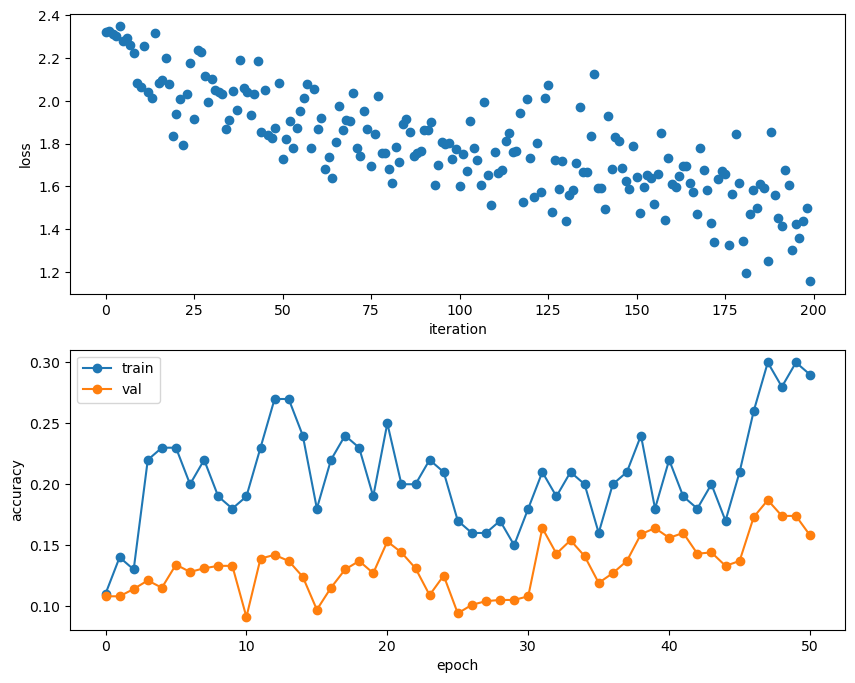

In [24]:
# Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

<font size='4' color='red'>**4.2: Train a good CNN (10 points).**
    
<font size='4'>By tweaking different hyper parameters, such as number of convolution layers, number of filters (channels), learning rate, batch size, etc, you should achieve greater than 62% accuracy on the validation set **with 3 epochs using the sgd_momentum optimizer**.
    
<font size='4'>If you are really careful, you should be able to get nearly 66% accuracy on the validation set. But we don't give extra credits for doing so.
    
<font size='4'>It may take a quite while for your training to be finished. **Do not use more than four convolution layers. Your training shouldn't be longer than one hour.** (This is a rough reference as it depends on the hardware. Our implementation takes less than 10 minutes to finish.)
    
<font size='4'>Use a large filter/kernel size in the first convolution layer (for example, 7), so you can easily visualize the learend filters.
    
<font size='4'>Since it is relatively slower to train a CNN, you can simply report the best hyper parameters you found. You need report validation accuracy of other choices below.
    
<font size='4' color='red'>For debuging purpose, you can simply train the model for a single epoch. As a reference, both your training and validation accuracy should be around 50% (could be slightly lower or higher). Once you figure a good setting, train the model for 3 epochs.

In [25]:
best_model = None
model = None
validation_test_accuracy = 0.0
################################################################################
# TODO: Train the best ConvNet that you can on CIFAR-10 with 3 epochs using    #
# the sgd_momentum optimizer. Store your best model in the model variable.     #
################################################################################

# raise NotImplementedError

np.random.seed(231)

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[32, 32],
    filter_sizes=[5,5],
    weight_scale=1e-2

)

solver = Solver(
    model, small_data,
    num_epochs=3, batch_size=75,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 5e-2,
    },
    verbose=True, print_every=10
)
solver.train()


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

best_model = model
best_model.params.update(solver.best_params)

(Iteration 1 / 39) loss: 2.298742
(Epoch 0 / 3) train acc: 0.093000; val_acc: 0.073000
(Iteration 11 / 39) loss: 2.224563
(Epoch 1 / 3) train acc: 0.146000; val_acc: 0.131000
(Iteration 21 / 39) loss: 2.050658
(Epoch 2 / 3) train acc: 0.187000; val_acc: 0.184000
(Iteration 31 / 39) loss: 1.996140
(Epoch 3 / 3) train acc: 0.165000; val_acc: 0.169000


In [26]:
# Run your best model on the validation and test sets. You should achieve above 62% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.184
Test set accuracy:  0.161


### Visualize Filters

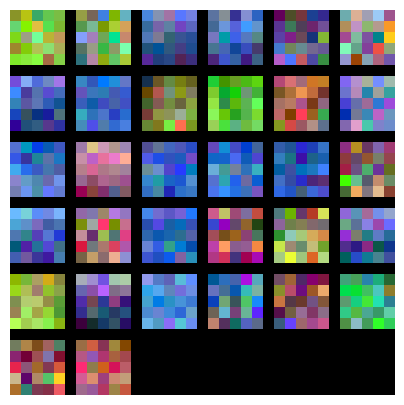

In [31]:
# You can visualize the first-layer convolutional filters from the trained network by running the following:
from utils.vis_utils import visualize_grid
grid = visualize_grid(model.params['w0'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

<font size='4' color='red'>**Task 4.3: report validation accuray for other hyper parameters you have tried (2 points)**

1. Set 1:
  num_filters=[16, 32],
      filter_sizes=[7,5],
      weight_scale=1e-2
      batch_size=50,
      optim_config={
        'learning_rate': 5e-2,

        Validation accuracy= 10.7 %

  num_filters=[16, 32],
      filter_sizes=[5, 5],
      weight_scale=4e-2
      batch_size=50,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy=12 %


  num_filters=[16, 32,32,32],
      filter_sizes=[7, 7,5,5],
      weight_scale=1e-2
      batch_size=50,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy=11.9 %


  num_filters=[16, 32],
      filter_sizes=[7, 3],
      weight_scale=1e-2
      batch_size=50,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy= 12.1 %



  num_filters=[16, 32],
      filter_sizes=[3, 5],
      weight_scale=1e-2
      batch_size=50,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy= 12.6 %



  num_filters=[16, 32],
      filter_sizes=[5, 5],
      weight_scale=4e-2
      batch_size=50,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy= 12.5%



  num_filters=[32, 32],
      filter_sizes=[5, 5],
      weight_scale=1e-2
      batch_size=75,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy= %


  num_filters=[64, 64],
      filter_sizes=[7, 7],
      weight_scale=1e-2
      batch_size=75,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy= 11.9%



  num_filters=[16, 32,32,32],
      filter_sizes=[7, 7,5,5],
      weight_scale=1e-2
      batch_size=100,
      optim_config={
        'learning_rate': 5e-2,    

          Validation accuracy=11.9 %

  num_filters=[32,32],
    filter_sizes=[5, 5],
    weight_scale=1e-2
    batch_size=75,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 5e-2,

      Validation accuracy=18.4% 


<font size='4' color='red'>**Task 4.4: train a ConvNet without using batch normalization layers (4 points).**
    
<font size='4'>Report the best validation accuracy you can get and discuss how it is different from the version with batch normalization layers.

In [32]:
best_model = None
model = None
validation_test_accuracy = 0.0
################################################################################
# TODO: Train the best ConvNet that you can on CIFAR-10 with 3 epochs using    #
# the sgd_momentum optimizer. Store your best model in the model variable.     #
################################################################################

# raise NotImplementedError

np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[32, 32],
    filter_sizes=[5,5],
    weight_scale=1e-2,
    use_batch_norm=False

)

solver = Solver(
    model, small_data,
    num_epochs=3, batch_size=75,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': 5e-2,
    },
    verbose=True, print_every=10
)
solver.train()
 
validation_test_accuracy=solver.best_val_acc           
print ("Best Validation accuracy is: " + str(validation_test_accuracy ))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

best_model = model
best_model.params.update(solver.best_params)

(Iteration 1 / 3) loss: 2.305342
(Epoch 1 / 3) train acc: 0.110000; val_acc: 0.122000
(Epoch 2 / 3) train acc: 0.150000; val_acc: 0.125000
(Epoch 3 / 3) train acc: 0.130000; val_acc: 0.111000
Best Validation accuracy is: 0.125


This model does not normalize data in batches after convolution layer. Instead, it directly passes whole dataset to relu layer. It performed faster but acheived lower accuracy for same hyperparameters.